<a href="https://colab.research.google.com/github/RoyBensimon/EnergyVoice_Capgemini/blob/main/Copie_de_Minimal_DDM(3)_init_student_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Lab: Exploring Generative Models on MNIST

Welcome to this lab session!

In this notebook, we will explore three generative models applied to the MNIST dataset: a minimal GAN, a minimal VAE, and a simplified Denoising Diffusion Model (DDM).

We will implement each model step by step, visualize the results, and understand the underlying mechanisms.

In [ ]:
### Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [ ]:
# Import requests library to fetch code from a URL (used for sending data)
import requests

# Execute code fetched from a remote server (used for tracking or submission)
exec(requests.get("https://raw.githubusercontent.com/claireBoyer/tutorial-conformal-prediction/main/labs/aux-npt/get-send-code.html").content)

# Configuration settings for the session
npt_config = {
    'session_name': 'Unsupervised-DL-DDM',
    'session_owner': 'aymeric',
    'sender_name': input("Your name:"),  # Enter your name
}

# Send a message indicating that the session has started
send('Started', 0)

Your name:Aymeric Dieuleveut


<Response [200]>

## **Section 1: Minimal GAN on MNIST**

In this section, we'll implement a simple Generative Adversarial Network (GAN) to generate handwritten digits similar to those in the MNIST dataset.

In [ ]:
### Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
### Define Hyperparameters

batch_size = 64
z_dim = 100
lr = 0.0002
num_epochs = 10

In [ ]:
### Load MNIST Dataset**
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

mnist_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(mnist_data, batch_size=batch_size, shuffle=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 20.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.7MB/s]


In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)
send(Generator, 1)
send(Discriminator, 2)

<Response [200]>

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

generator = Generator(z_dim).to(device)
discriminator = Discriminator().to(device)

In [ ]:
### Define Loss Function and Optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)


In [ ]:
### Training Loop
for epoch in range(num_epochs):
    for batch_idx, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs.view(-1, 784).to(device)
        batch_size = real_imgs.size(0)

        # Labels for real and fake images
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        discriminator.zero_grad()

        # Real images
        outputs = discriminator(real_imgs)
        d_loss_real = criterion(outputs, real_labels)

        # Fake images
        z = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = generator(z)
        outputs = discriminator(fake_imgs.detach())
        d_loss_fake = criterion(outputs, fake_labels)

        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------
        generator.zero_grad()

        # Generate fake images
        z = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = generator(z)
        outputs = discriminator(fake_imgs)

        # Generator tries to fool the discriminator
        g_loss = criterion(outputs, real_labels)
#         -torch.mean(torch.log(D_scores_on_fake))
        g_loss.backward()
        optimizer_G.step()

        if batch_idx % 200 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {d_loss.item():.4f}, Loss G: {g_loss.item():.4f}")


Epoch [1/10] Batch 0/938                   Loss D: 1.3872, Loss G: 0.7178
Epoch [1/10] Batch 200/938                   Loss D: 0.5070, Loss G: 1.0784
Epoch [1/10] Batch 400/938                   Loss D: 0.2663, Loss G: 5.1177
Epoch [1/10] Batch 600/938                   Loss D: 0.1484, Loss G: 5.0689
Epoch [1/10] Batch 800/938                   Loss D: 0.0732, Loss G: 6.8868
Epoch [2/10] Batch 0/938                   Loss D: 0.1382, Loss G: 5.0847
Epoch [2/10] Batch 200/938                   Loss D: 0.4555, Loss G: 6.3375
Epoch [2/10] Batch 400/938                   Loss D: 0.2949, Loss G: 5.9722
Epoch [2/10] Batch 600/938                   Loss D: 0.8333, Loss G: 1.7741
Epoch [2/10] Batch 800/938                   Loss D: 0.2590, Loss G: 3.6130
Epoch [3/10] Batch 0/938                   Loss D: 0.5428, Loss G: 3.9072
Epoch [3/10] Batch 200/938                   Loss D: 0.4921, Loss G: 2.8036
Epoch [3/10] Batch 400/938                   Loss D: 0.9886, Loss G: 3.5740
Epoch [3/10] Batch

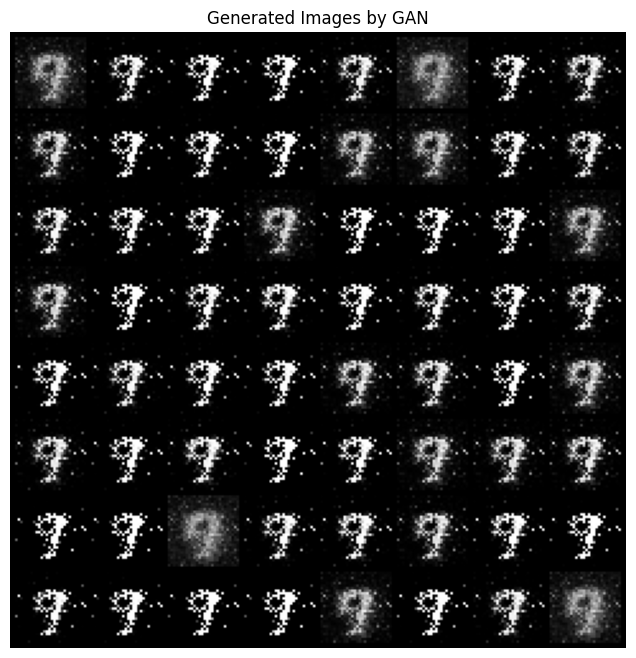

In [ ]:
### Generate and Visualize Images

# Generate images
generator.eval()
with torch.no_grad():
    z = torch.randn(64, z_dim).to(device)
    fake_imgs = generator(z).view(-1, 1, 28, 28).cpu()

# Denormalize and plot
grid_img = torchvision.utils.make_grid(fake_imgs, nrow=8, normalize=True)
plt.figure(figsize=(8,8))
plt.imshow(grid_img.permute(1, 2, 0))
plt.title("Generated Images by GAN")
plt.axis('off')
send(plt, 3)
plt.show()


In [ ]:
## **Comment on the results**
# - quality of the images
# - quality

SyntaxError: invalid syntax (ipython-input-3217693898.py, line 2)

In [ ]:
send("your comments", 4)

send("with following changes: ...", 5)
# I get the following plot
send(plt, 6)

! Warning, your figure is blank !
Make sure the send function is in the same cell as the plot, or send the matplotlib figure itself.


<Response [200]>

<Figure size 640x480 with 0 Axes>


---

## **Section 2: Minimal VAE on MNIST**

In this section, we'll implement a simple Variational Autoencoder (VAE) to generate handwritten digits similar to those in the MNIST dataset.

### **2.1 Define the VAE Model**

In [ ]:
class VAE(nn.Module):
    def __init__(self, x_dim=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(x_dim, h_dim)
        self.fc_mu = nn.Linear(h_dim, z_dim)
        self.fc_logvar = nn.Linear(h_dim, z_dim)
        # Decoder
        self.fc3 = nn.Linear(z_dim, h_dim)
        self.fc4 = nn.Linear(h_dim, x_dim)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

vae = VAE().to(device)


In [ ]:
### Define Loss Function and Optimizer
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

def loss_function(x_recon, x, mu, logvar):
    x = (x + 1) / 2
    BCE = nn.functional.binary_cross_entropy(x_recon, x.view(-1, 784), reduction='sum')
    # KL Divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [ ]:
### Training Loop
num_epochs = 5
vae.train()

for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        x_recon, mu, logvar = vae(data)
        loss = loss_function(x_recon, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 200 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch {batch_idx}/{len(dataloader)} Loss: {loss.item() / len(data):.4f}")


Epoch [1/5] Batch 0/938 Loss: 551.3997
Epoch [1/5] Batch 200/938 Loss: 153.0931
Epoch [1/5] Batch 400/938 Loss: 135.6612
Epoch [1/5] Batch 600/938 Loss: 134.8802
Epoch [1/5] Batch 800/938 Loss: 124.3897
Epoch [2/5] Batch 0/938 Loss: 125.4517
Epoch [2/5] Batch 200/938 Loss: 117.0020
Epoch [2/5] Batch 400/938 Loss: 124.7222
Epoch [2/5] Batch 600/938 Loss: 109.3381
Epoch [2/5] Batch 800/938 Loss: 116.2509
Epoch [3/5] Batch 0/938 Loss: 114.8771
Epoch [3/5] Batch 200/938 Loss: 105.9651
Epoch [3/5] Batch 400/938 Loss: 108.7796
Epoch [3/5] Batch 600/938 Loss: 111.1081
Epoch [3/5] Batch 800/938 Loss: 110.8213
Epoch [4/5] Batch 0/938 Loss: 114.0476
Epoch [4/5] Batch 200/938 Loss: 110.8055
Epoch [4/5] Batch 400/938 Loss: 114.7016
Epoch [4/5] Batch 600/938 Loss: 112.3605
Epoch [4/5] Batch 800/938 Loss: 107.6911
Epoch [5/5] Batch 0/938 Loss: 109.2687
Epoch [5/5] Batch 200/938 Loss: 119.0337
Epoch [5/5] Batch 400/938 Loss: 107.8762
Epoch [5/5] Batch 600/938 Loss: 107.5085
Epoch [5/5] Batch 800/938 

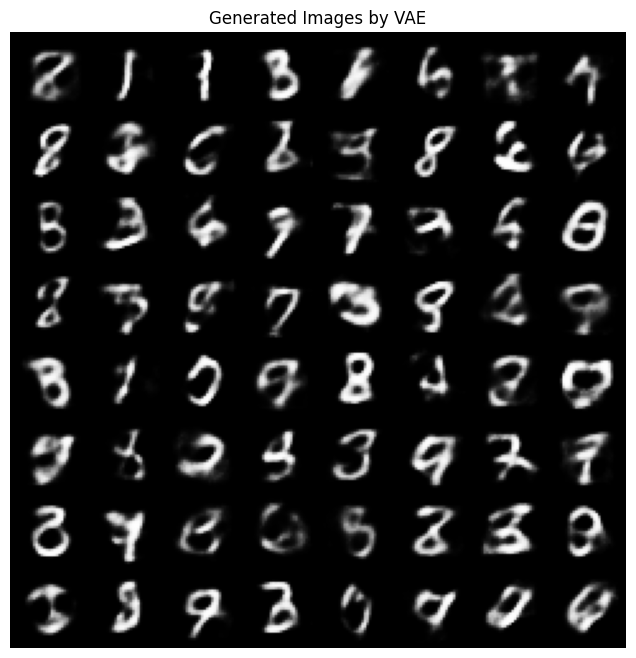

In [ ]:
### Generate and Visualize Images
vae.eval()
with torch.no_grad():
    z = torch.randn(64, 20).to(device)
    sample = vae.decode(z).cpu()

# Plot the generated images
grid_img = torchvision.utils.make_grid(sample.view(-1, 1, 28, 28), nrow=8)
plt.figure(figsize=(8,8))
plt.imshow(grid_img.permute(1, 2, 0))
plt.title("Generated Images by VAE")
plt.axis('off')
send(plt, 7)
plt.show()


### **Questions:**

1. **Explain the purpose of the KL divergence term in the VAE loss function.**

2. **What would happen if we remove the reparameterization trick in the VAE?**

In [ ]:
send("[réponse q3 à remplir]", 8)

<Response [200]>

In [ ]:
send("[réponse q4 à remplir]", 9)

<Response [200]>

---

## **Section 3: Simplified Denoising Diffusion Model on MNIST**

In this section, we'll implement a simplified version of a Denoising Diffusion Model (DDM) step by step.

In [ ]:
### Define Hyperparameters
num_epochs = 10
timesteps = 100  # Number of diffusion steps
beta_start = 1e-4
beta_end = 0.02
batch_size = 128
lr = 2*1e-4


import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# 1. Define the Transform (including the normalization to [-1, 1])
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x * 2) - 1)
])

# 2. Load the Dataset (pass the transform here)
dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# 3. Create the DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True
)


In [ ]:
### Precompute Beta Schedule and Other Constants
import numpy as np

# Convert betas to PyTorch Tensor
betas = torch.tensor(np.linspace(beta_start, beta_end, timesteps), dtype=torch.float32).to(device)

# Ensure 'alphas' is a PyTorch Tensor
# alphas = torch.tensor(alphas, dtype=torch.float32).to(device)

# Compute alphas and related constants as Tensors
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = torch.cat([torch.tensor([1.0], device=device), alphas_cumprod[:-1]])

sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

In [ ]:
### Functions for Forward Diffusion Process (Adding Noise)
def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]

    out = vals.gather(-1, t.to(vals.device))

    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))

def forward_diffusion_sample(x_0, t):
    """
    Takes an image and a timestep as input, and returns the noisy version of it
    according to the forward diffusion process.
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
    return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise, noise


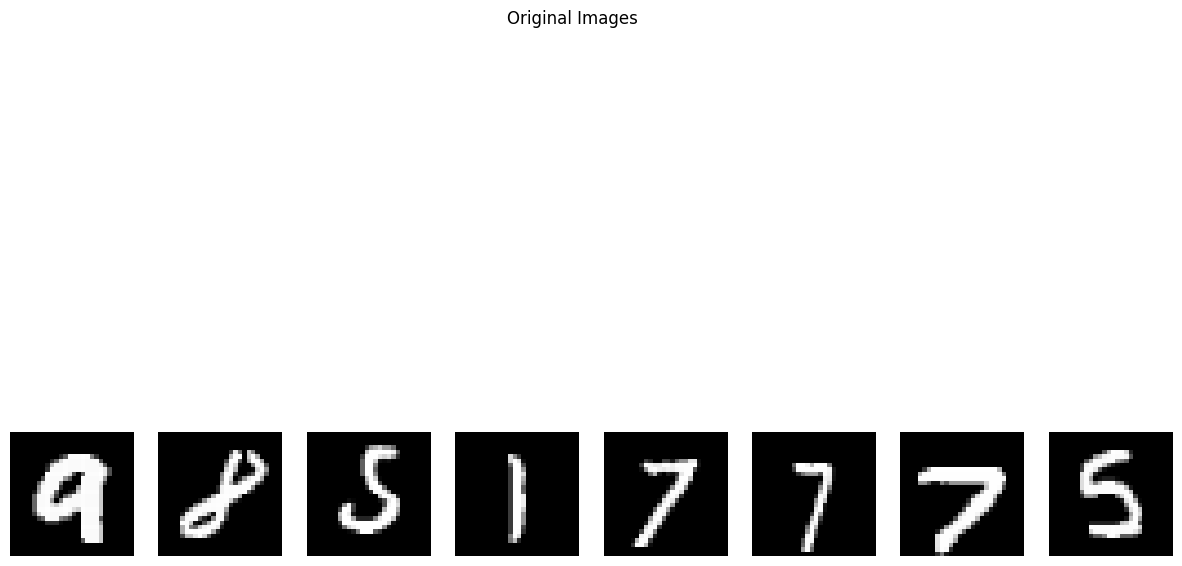

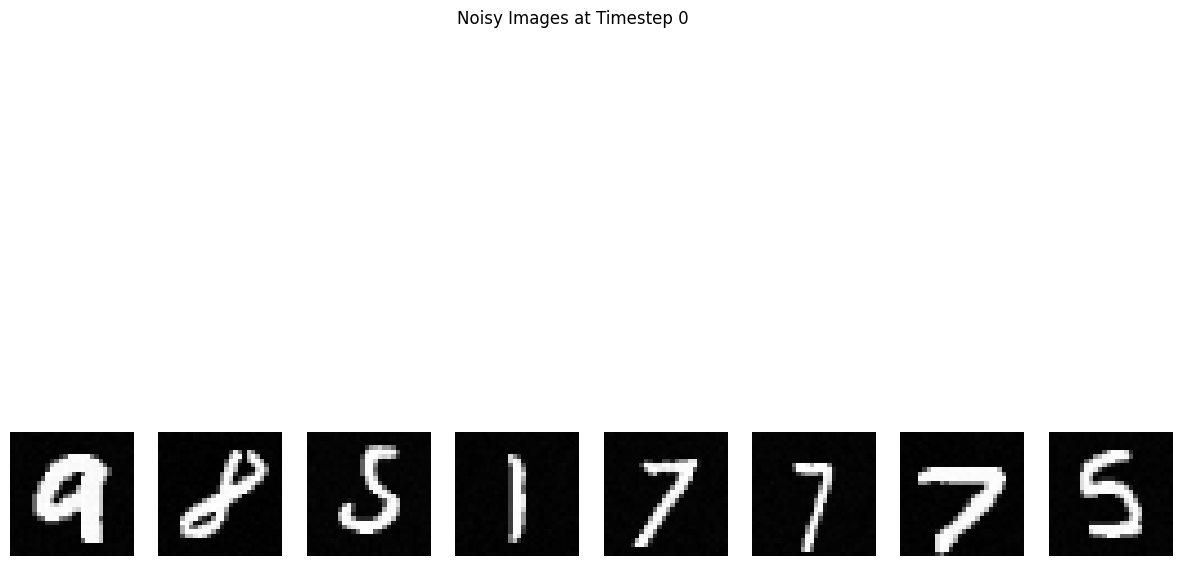

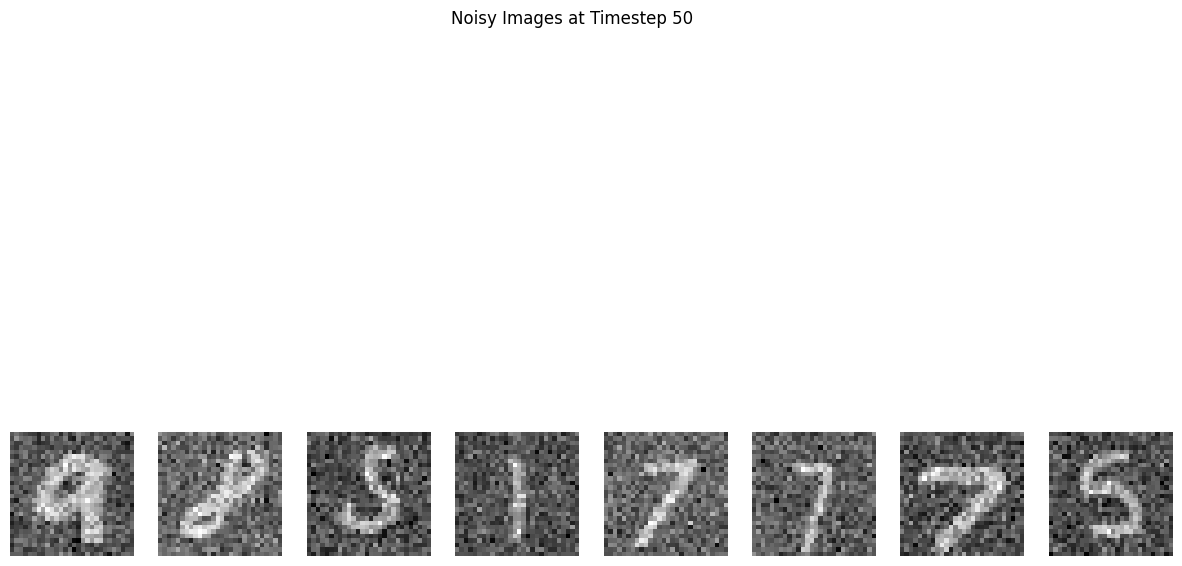

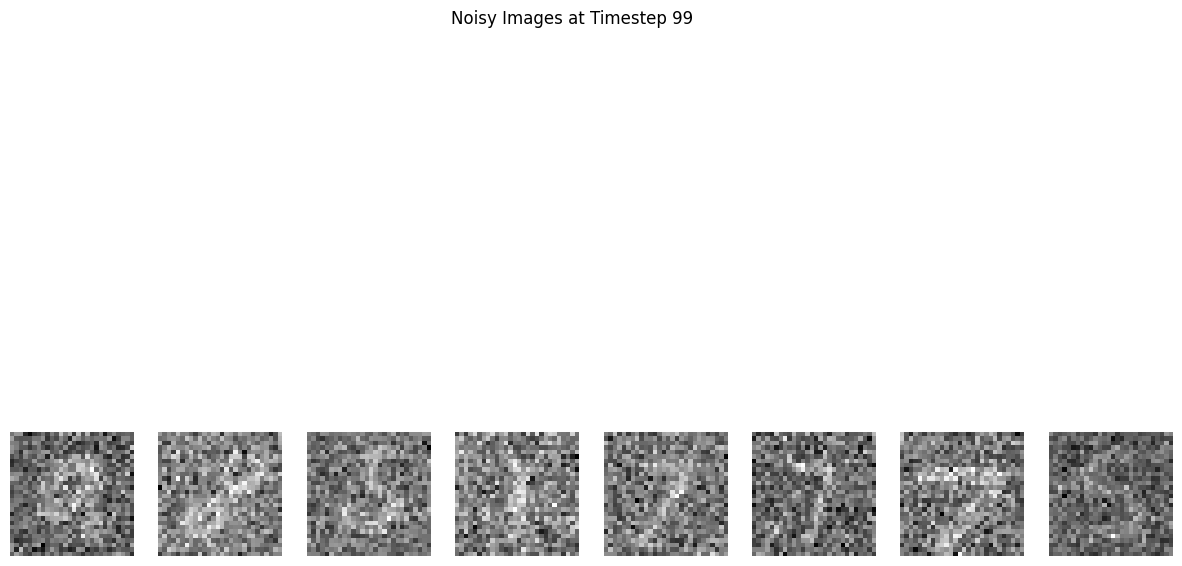

In [ ]:
### Visualize Noisy Images at Different Timesteps
import random

# Sample some images
imgs, _ = next(iter(dataloader))
imgs = imgs[:8].to(device)
plt.figure(figsize=(15,10))
for idx, img in enumerate(imgs):
    plt.subplot(1,8,idx+1)
    plt.imshow(img.cpu().squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle('Original Images')
plt.show()

# Visualize at different timesteps
noisy_imgs = []
timesteps_to_plot = [0, 50, 99]#, 200, 500, 999]
for t in timesteps_to_plot:
    noisy_img, _ = forward_diffusion_sample(imgs, torch.tensor([t]*imgs.shape[0]).to(device))
    noisy_imgs.append(noisy_img)

for i, t in enumerate(timesteps_to_plot):
    plt.figure(figsize=(15,10))
    for idx in range(8):
        plt.subplot(1,8,idx+1)
        plt.imshow(noisy_imgs[i][idx].cpu().squeeze(), cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Noisy Images at Timestep {t}')
    send(plt, 10)
    plt.show()


### **Question:**

- **How does the noise level change with increasing timesteps?**

In [ ]:
### Define the Denoising Model (Simple U-Net Like CNN)
class SimpleDenoiser(nn.Module):
    def __init__(self, n_channels=1, n_feat=64):
        super(SimpleDenoiser, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(n_channels, n_feat, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(n_feat, n_feat, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(n_feat, n_channels, kernel_size=3, padding=1),
        )

    def forward(self, x, t):
        # Embed t into the network if desired
        return self.net(x)

send(SimpleDenoiser, 11)
model = SimpleDenoiser().to(device)


In [ ]:
class ImprovedDenoiser(nn.Module):
    def __init__(self, n_channels=1, n_feat=64, timesteps=100):
        super(ImprovedDenoiser, self).__init__()
        self.time_embed = nn.Embedding(timesteps, n_feat)

        # Define layers
        self.conv1 = nn.Conv2d(n_channels, n_feat, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_feat, n_feat, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_feat, n_channels, kernel_size=3, padding=1)

        # Define Activation
        self.relu = nn.ReLU() # Or nn.SiLU()

    def forward(self, x, t):
        # Embed time
        t_emb = self.time_embed(t).view(t.size(0), -1, 1, 1)

        # Layer 1
        x = self.conv1(x)
        x = self.relu(x)

        # Inject time
        x = x + t_emb

        # Layer 2
        x = self.conv2(x)
        x = self.relu(x)

        # Layer 3 (Output usually has no activation or Tanh depending on normalization)
        x = self.conv3(x)
        return x

In [ ]:
### Define Loss Function and Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
mse_loss = nn.MSELoss()


In [ ]:
device

device(type='cuda')

In [ ]:
### Training Loop
from tqdm.notebook import tqdm

for epoch in range(num_epochs):
    model.train()
    pbar = tqdm(dataloader)
    for batch_idx, (x, _) in enumerate(pbar):
        x = x.to(device)
        t = torch.randint(0, timesteps, (x.size(0),), device=device).long()
        x_noisy, noise = forward_diffusion_sample(x, t)

        # Predict the noise
        noise_pred = model(x_noisy, t)

        loss = mse_loss(noise_pred, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}] Loss: {loss.item():.4f}")


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

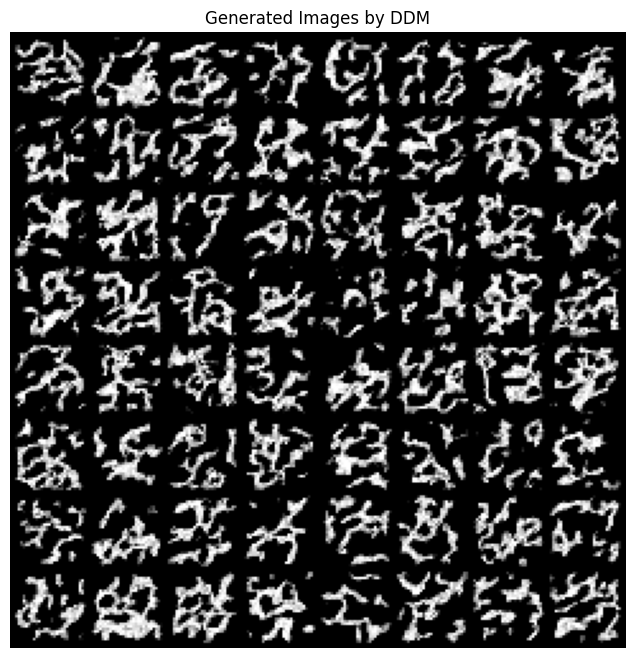

In [ ]:
### Sampling (Reverse Process)

@torch.no_grad()
def sample(model, n_samples):
    model.eval()
    x = torch.randn(n_samples, 1, 28, 28).to(device)
    for t in reversed(range(0, timesteps)):
        t_batch = torch.tensor([t]*n_samples, device=device).long()
        predicted_noise = model(x, t_batch)
        alpha = alphas[t]
        alpha_cumprod_t = alphas_cumprod[t]
        beta = betas[t]

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_cumprod_t)) * predicted_noise) + torch.sqrt(beta) * noise
    return x

# Generate samples
samples = sample(model, n_samples=64).cpu()

# Plot the generated images
grid_img = torchvision.utils.make_grid(samples, nrow=8)
plt.figure(figsize=(8,8))
plt.imshow(grid_img.permute(1, 2, 0).squeeze(), cmap='gray')
plt.title("Generated Images by DDM")
plt.axis('off')
send(plt, 12)
plt.show()


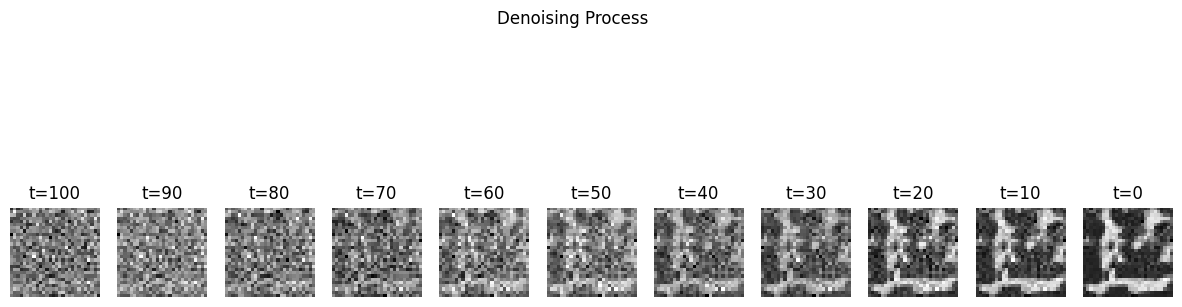

In [ ]:
@torch.no_grad()
def sample_with_intermediate_steps(model, x, n_steps):
    model.eval()
    xs = [x.cpu()]

    # Calculate the interval to save images
    save_interval = timesteps // n_steps

    # Run the FULL loop t: 99 -> 0
    for t in reversed(range(0, timesteps)):
        t_batch = torch.tensor([t]*x.size(0), device=device).long()
        predicted_noise = model(x, t_batch)

        # ... (Rest of your sampling logic remains the same) ...
        alpha = alphas[t]
        alpha_cumprod_t = alphas_cumprod[t]
        beta = betas[t]

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_cumprod_t)) * predicted_noise) + torch.sqrt(beta) * noise

        # CORRECTION: Only append to list if we hit the interval
        if t % save_interval == 0 or t == 0:
            xs.append(x.cpu())

    return xs

# Start from random noise
x = torch.randn(1, 1, 28, 28).to(device)
n_steps = 10
intermediate_images = sample_with_intermediate_steps(model, x, n_steps)

# Plot the intermediate images
plt.figure(figsize=(15,5))
for idx, img in enumerate(intermediate_images):
    plt.subplot(1, n_steps+1, idx+1)
    plt.imshow(img[0].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(f"t={timesteps - idx*(timesteps // n_steps)}")
plt.suptitle('Denoising Process')
send(plt, 13)
plt.show()


### **Questions:**

1. **What differences do you observe in the generated images between the GAN, VAE, and DDM?**

2. **How does the denoising network's architecture impact the quality of the generated images?**

3. **Experiment with changing the number of timesteps in the diffusion process. How does it affect the results?**

---

### **Visualizing Forward and Reverse Processes**

- **Forward Process Visualization:**

  - We have already visualized how images become noisier over time in section 3.4.

- **Reverse Process Visualization:**

  - In section 3.9, we visualized the denoising process step by step.

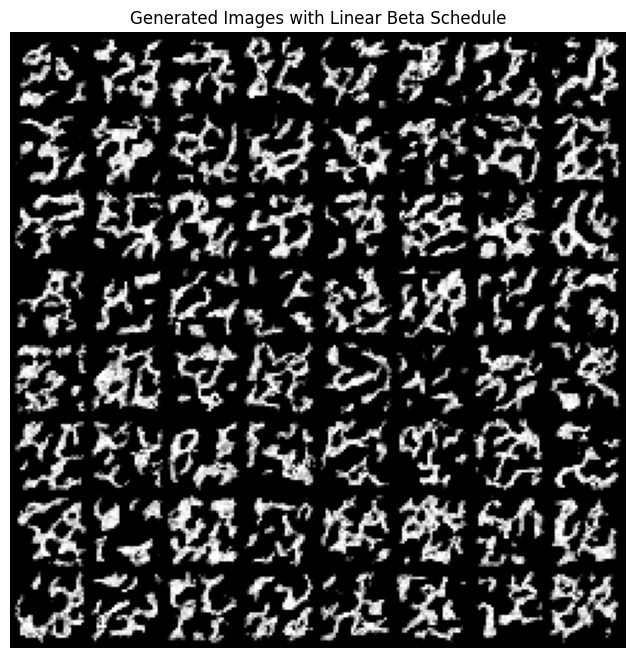

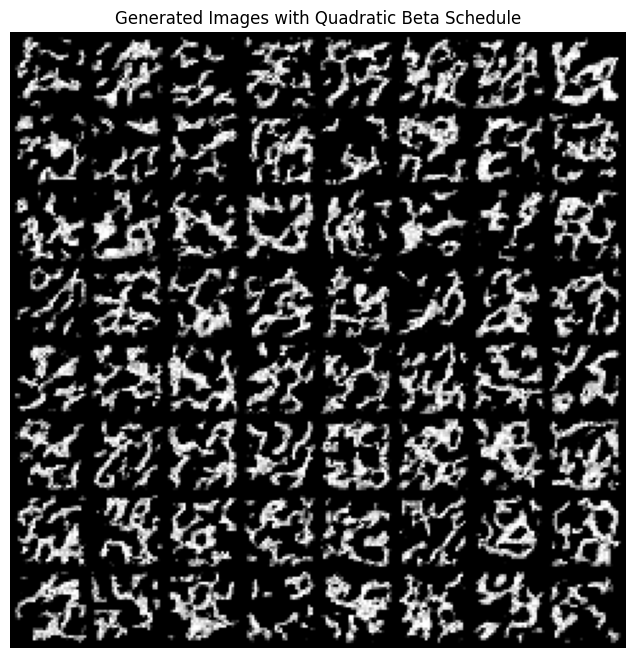

In [ ]:
### **Analyzing the Effect of Beta Schedules**


# Try different beta schedules and observe the results
beta_schedules = {
    'linear': np.linspace(beta_start, beta_end, timesteps),
    'quadratic': np.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2,
}

for name, beta_schedule in beta_schedules.items():
    betas = torch.tensor(beta_schedule, dtype=torch.float32).to(device)
    alphas = 1 - betas
    alphas_cumprod = torch.cumprod(alphas, 0)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

    # Rest of the code remains the same for sampling...
    # Generate samples
    samples = sample(model, n_samples=64).cpu()

    # Plot the generated images
    grid_img = torchvision.utils.make_grid(samples, nrow=8)
    plt.figure(figsize=(8,8))
    plt.imshow(grid_img.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.title(f"Generated Images with {name.capitalize()} Beta Schedule")
    plt.axis('off')
    send(plt, 14)
    plt.show()


### **Question:**

- **How does changing the beta schedule affect the diffusion and generation processes?**

---

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


In [ ]:

batch_size = 128
num_epochs = 100      # 15 should be enough to see digits form, 30+ is probably better, feel free to push it!
lr = 1e-3            # Important hyperparam...

# super important param: timestep. Play with it.
timesteps = 500      # 500 steps is seemingly good balance for MNIST


beta_start = 1e-4
beta_end = 0.02



In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1)
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)



In [ ]:
# Define beta schedule
betas = torch.linspace(beta_start, beta_end, timesteps).to(device)

# Pre-calculate different terms for closed form diffusion
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = torch.cat([torch.tensor([1.0], device=device), alphas_cumprod[:-1]])
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def forward_diffusion_sample(x_0, t):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)

    return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise, noise




#  Define U-Net Model


In [ ]:

class MiniUNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Time embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32)
        )

        # Encoder (Downsampling)
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.pool1 = nn.Conv2d(32, 32, 4, 2, 1) # Downsample 28 -> 14

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.Conv2d(64, 64, 4, 2, 1) # Downsample 14 -> 7

        # Bottleneck
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        # Decoder (Upsampling)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, 2) # Upsample 7 -> 14
        self.conv4 = nn.Conv2d(128, 64, 3, padding=1) # 128 because of concat (64+64)

        self.up2 = nn.ConvTranspose2d(64, 32, 2, 2) # Upsample 14 -> 28
        self.conv5 = nn.Conv2d(64, 32, 3, padding=1) # 64 because of concat (32+32)

        self.conv_out = nn.Conv2d(32, 1, 3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        # Time Embed
        t = t.float().view(-1, 1) / timesteps # Normalize time
        t_emb = self.time_mlp(t)
        t_emb = t_emb.view(-1, 32, 1, 1)

        # --- Encoder ---
        x1 = self.relu(self.conv1(x))
        x2 = self.pool1(x1 + t_emb)

        x2 = self.relu(self.conv2(x2))
        x3 = self.pool2(x2)

        # --- Bottleneck ---
        x3 = self.relu(self.conv3(x3))

        # --- Decoder ---
        x_up1 = self.up1(x3)
        # Skip connection: Concatenate x_up1 with x2 (must match sizes)
        x_up1 = torch.cat([x_up1, x2], dim=1)
        x4 = self.relu(self.conv4(x_up1))

        x_up2 = self.up2(x4)
        # Inject time again just before final layers (optional but helps)
        x_up2 = x_up2 + t_emb
        # Skip connection: Concatenate x_up2 with x1
        x_up2 = torch.cat([x_up2, x1], dim=1)
        x5 = self.relu(self.conv5(x_up2))

        return self.conv_out(x5)

model = MiniUNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()



In [ ]:
print("Starting Training...")
loss_history = []

for epoch in range(num_epochs):
    model.train()
    pbar = tqdm(dataloader)
    epoch_loss = 0

    for x, _ in pbar:
        x = x.to(device)
        t = torch.randint(0, timesteps, (x.size(0),), device=device).long()

        x_noisy, noise = forward_diffusion_sample(x, t)
        noise_pred = model(x_noisy, t)

        loss = loss_fn(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pbar.set_description(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")

    loss_history.append(epoch_loss / len(dataloader))



Starting Training...


Epoch 1 | Loss: 0.0647: 100%|██████████| 468/468 [00:16<00:00, 28.26it/s]
Epoch 2 | Loss: 0.0477: 100%|██████████| 468/468 [00:16<00:00, 28.21it/s]
Epoch 3 | Loss: 0.0639: 100%|██████████| 468/468 [00:16<00:00, 29.02it/s]
Epoch 4 | Loss: 0.0487: 100%|██████████| 468/468 [00:16<00:00, 28.01it/s]
Epoch 5 | Loss: 0.0399: 100%|██████████| 468/468 [00:16<00:00, 28.61it/s]
Epoch 6 | Loss: 0.0506: 100%|██████████| 468/468 [00:16<00:00, 28.25it/s]
Epoch 7 | Loss: 0.0474: 100%|██████████| 468/468 [00:16<00:00, 27.68it/s]
Epoch 8 | Loss: 0.0442: 100%|██████████| 468/468 [00:16<00:00, 28.36it/s]
Epoch 9 | Loss: 0.0387: 100%|██████████| 468/468 [00:16<00:00, 28.74it/s]
Epoch 10 | Loss: 0.0390: 100%|██████████| 468/468 [00:16<00:00, 27.68it/s]
Epoch 11 | Loss: 0.0468: 100%|██████████| 468/468 [00:16<00:00, 28.79it/s]
Epoch 12 | Loss: 0.0479: 100%|██████████| 468/468 [00:16<00:00, 28.43it/s]
Epoch 13 | Loss: 0.0438: 100%|██████████| 468/468 [00:16<00:00, 28.53it/s]
Epoch 14 | Loss: 0.0418: 100%|████

In [ ]:
@torch.no_grad()
def sample_image(model, n_samples=16):
    model.eval()
    # Start from pure noise (N(0,1))
    x = torch.randn(n_samples, 1, 28, 28).to(device)

    print("Sampling...")
    for t in tqdm(reversed(range(timesteps))):
        t_tensor = torch.tensor([t] * n_samples, device=device).long()
        predicted_noise = model(x, t_tensor)

        alpha = alphas[t]
        alpha_cumprod = alphas_cumprod[t]
        beta = betas[t]

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        # Algorithm 2 form DDPM paper
        x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_cumprod))) * predicted_noise) + torch.sqrt(beta) * noise

    return x


Sampling...


500it [00:00, 700.60it/s]


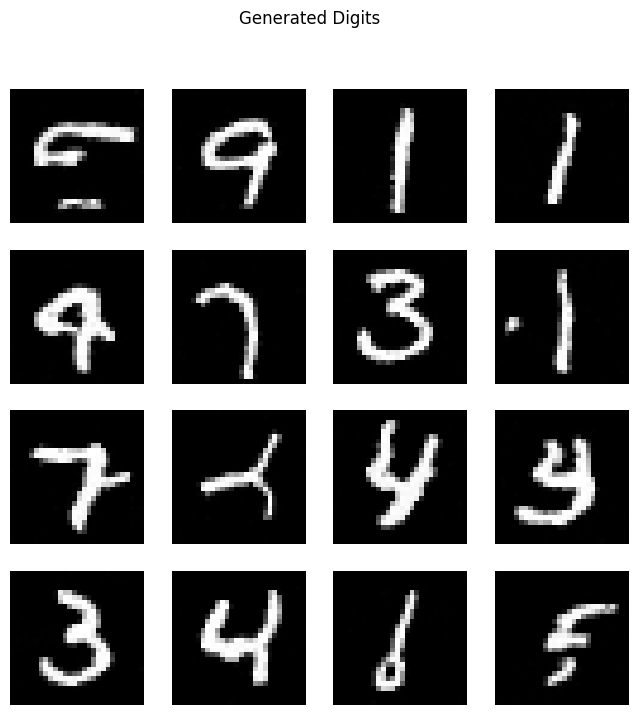

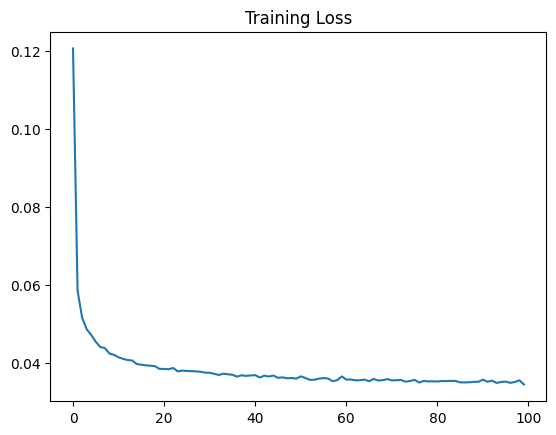

In [ ]:

# Generate and Plot
model.eval()
samples = sample_image(model, n_samples=16)

# Un-normalize from [-1, 1] to [0, 1] for display
samples = (samples.clamp(-1, 1) + 1) / 2
samples = samples.cpu()

plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(samples[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle("Generated Digits")
send(plt, 15)
plt.show()

plt.figure()
plt.plot(loss_history)
plt.title("Training Loss")

send(plt, 16)
plt.show()


In [ ]:
# time per epoch on t4: 16 secs

## **Questions**
Play with hyperparameters to improve generation, e.g:
- larger learning rate
- number of epochs
- architecture
- beta-schedule
- number of timesteps


Report your conclusions below using send (use individual numbers from 17+) functions



In [ ]:
send("with hyperparameters ...., i get the follwoing digits", 17)
send(plt, 21) # place send(plt, 18) before plt.show() !!

send("with hyperparameters ...., architecture ..., I get the follwoing digits", 19)
send(plt, 23) # place send(plt, 20) before plt.show() !!

send("I have observed that...", 21)

! Warning, your figure is blank !
Make sure the send function is in the same cell as the plot, or send the matplotlib figure itself.
! Warning, your figure is blank !
Make sure the send function is in the same cell as the plot, or send the matplotlib figure itself.


<Response [200]>

<Figure size 640x480 with 0 Axes>

## **Conclusion**

In this lab, we've implemented and compared three generative models: GAN, VAE, and DDM. Through hands-on coding and visualization, we've gained insights into how these models learn to generate new data and the underlying mechanisms that differentiate them.